In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
img_rows = 28
img_cols = 28
channels =1

img_shape = (img_rows,img_cols,channels)
z_dim =100

In [3]:
class generator(tf.keras.Model):
    def __init__(self,z_dim):
        super(generator,self).__init__()
        self.dense1 = tf.keras.layers.Dense(7*7*256,input_dim=(100,))
        self.reshape = tf.keras.layers.Reshape((7,7,256))
        
        self.conv1 = tf.keras.layers.Conv2DTranspose(128,kernel_size=5,strides=1,padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        
        self.conv2 = tf.keras.layers.Conv2DTranspose(64,kernel_size=5,strides=2,padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        
        self.conv3 = tf.keras.layers.Conv2DTranspose(1,kernel_size=5,strides=2,padding='same')
    
    def call(self, input_tensor, training =False):
        x = self.dense1(input_tensor)
        x = self.reshape(x)
        
        x = self.conv1(x)
        x = self.bn1(x, training = training)
        x = tf.nn.leaky_relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x, training = training)
        x = tf.nn.leaky_relu(x)
        
        x = self.conv3(x)
        x = tf.nn.tanh(x)
        return x        

In [4]:
class discriminator(tf.keras.Model):
    def __init__(self,img_shape):
        super(discriminator,self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(32,kernel_size=3,strides=2,padding='same')        
        self.conv2 = tf.keras.layers.Conv2D(64,kernel_size=3,strides=2,padding='same')
        self.conv3 = tf.keras.layers.Conv2D(128,kernel_size=3,strides=2,padding='same')
        self.global_avg = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(1)
        
    def call(self, input_tensor, training =False):
        x = self.conv1(input_tensor)
        x = tf.nn.leaky_relu(x,alpha=0.2)

        x = self.conv2(x)
        x = tf.nn.leaky_relu(x,alpha=0.2)

        x = self.conv3(x)
        x = tf.nn.leaky_relu(x,alpha=0.2)
        
        x = self.global_avg(x)
        x = self.fc1(x)
        x = tf.nn.sigmoid(x)
        return x      

In [5]:
g = generator(100)
d = discriminator(img_shape)

In [6]:
generator_optimizer = tf.keras.optimizers.Adam()
discriminator_optimizer = tf.keras.optimizers.Adam()

def generator_loss(fake_output):
    return tf.keras.losses.BinaryCrossentropy()(tf.ones_like(fake_output),fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(real_output),real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy()(tf.zeros_like(fake_output),fake_output)
    return 0.5 * (real_loss + fake_loss)

In [7]:
def sample_images(generator, image_grid_rows=4, image_grid_cols=4):
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_cols, z_dim))
    gen_imgs = generator(z)
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(image_grid_rows, image_grid_cols, figsize=(4,4),sharey=True, sharex=True)

    cnt =0
    for i in range(image_grid_rows):
        for j in range(image_grid_cols):
            axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt+=1

iteration : 1000 G loss = 0.0038 D loss = 0.0001
iteration : 2000 G loss = 0.0013 D loss = 0.0002
iteration : 3000 G loss = 0.0012 D loss = 0.0001
iteration : 4000 G loss = 0.0007 D loss = 0.0001
iteration : 5000 G loss = 0.0007 D loss = 0.0000
iteration : 6000 G loss = 0.0006 D loss = 0.0000
iteration : 7000 G loss = 0.0005 D loss = 0.0000
iteration : 8000 G loss = 0.0003 D loss = 0.0000
iteration : 9000 G loss = 0.0004 D loss = 0.0000
iteration : 10000 G loss = 0.0004 D loss = 0.0000


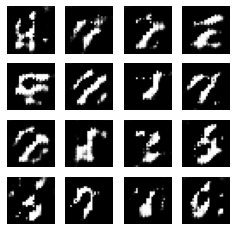

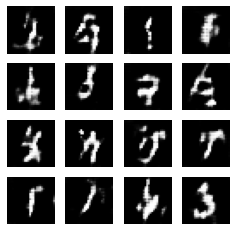

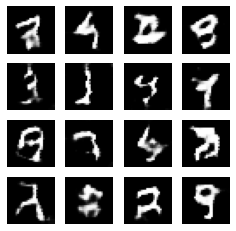

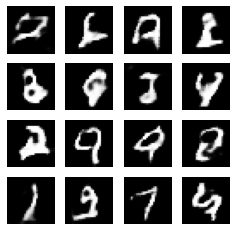

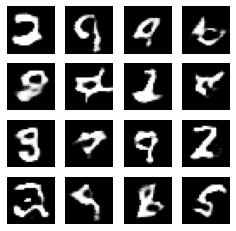

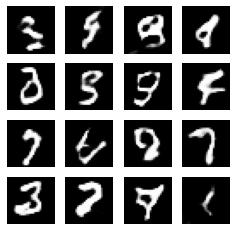

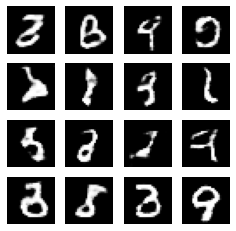

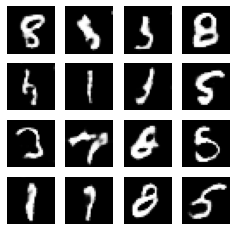

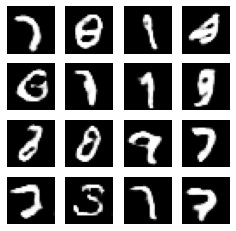

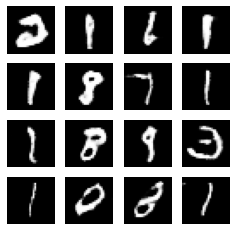

In [9]:
def train(iterations, batch_size, sample_interval):
    (x_train,_),(_,_) = tf.keras.datasets.mnist.load_data()

    x_train = x_train / 127.5 -1.0
    x_train = x_train[...,tf.newaxis]

    real  = np.ones((batch_size, 1))
    fake  = np.zeros((batch_size, 1))

    for iteration in range(1, iterations+1):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

            idx = np.random.randint(0, x_train.shape[0], batch_size)
            imgs = x_train[idx]

            z = np.random.normal(0, 1, (batch_size,100))
            
            generated_img = g(z, training=True)
            real_output = d(imgs, training=True)
            fake_output = d(generated_img, training=True)

            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

        gen_gradient = gen_tape.gradient(gen_loss, g.trainable_variables)
        disc_gradient = disc_tape.gradient(disc_loss, d.trainable_variables)

        generator_optimizer.apply_gradients(zip(gen_gradient, g.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(disc_gradient, d.trainable_variables))

        if iteration % sample_interval == 0:
            print(f'iteration : {iteration} G loss = {gen_loss:.4f} D loss = {disc_loss:.4f}')
            sample_images(g)

train(10000, 128, 1000)